In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import glob
import re

In [3]:
class Node:
    def __init__(self, l, num_packets, i):
        self.i=i
        self.l=l
        self.num_packets=num_packets
        self.inter_arrival_times=np.random.exponential(1/l, (num_packets))
        self.arrival_times=np.cumsum(self.inter_arrival_times)
        self.max_time=int(np.ceil(np.amax(self.arrival_times))+1) #transmitting till max_time
        self.queue=[]
        self.collisions=0
        self.successes=0
        self.transmit_flag=0
    
    def receive(self, t):
        #arrivals in (t-1, t) are appended to the queue
        for timestamp in self.arrival_times:
            if(t==np.ceil(timestamp)):
                self.queue.append(Packet(timestamp, self.i))
    def transmit(self, t):
        #if no collisions, and the queue is non-empty, transmit immediately
        if(self.collisions==0):
            if(len(self.queue)>0):
                transmitted_packet=self.queue[0]
                transmitted_packet.t_time=t
                self.transmit_flag=1
                return transmitted_packet
            else:
                self.transmit_flag=0
                return 0
        else:
            #collided packet
            if(len(self.queue)>0):
                if(self.queue[0].t_time==t):
                    transmitted_packet=self.queue[0]
                    transmitted_packet.t_time=t
                    self.transmit_flag=1
                    return transmitted_packet
                else:
                    self.transmit_flag=0
                    return 0
        

class Packet:
    def __init__(self, timestamp, i):
        self.timestamp=timestamp
        self.t_time=0
        self.i=i
        self.collisions=0


In [48]:
nodes=10
packets=500
epochs=1

In [49]:
input_G=np.linspace(0.1, 10, 25)
avr_results=np.zeros(len(input_G))
avr_delay=np.zeros(len(input_G))
for epoch in range(epochs):
    results=[]
    delay_results=[]
    for G in input_G:
        r_pkt=[]
        mynodes=[Node(G/nodes, packets, i) for i in range(nodes)]
        max_time=np.amax([mynodes[i].max_time for i in range(nodes)])

    #    print("Time, transmission time, Node, Collisions, Timestamp")
        for t in range(max_time):
            actives=[]
            t_packets=[]
            for node in mynodes:
                node.receive(t)
                pkt=node.transmit(t)
                if(pkt!=0):
                    #print(pkt.timestamp, pkt.i)
                    actives.append(node)
                    t_packets.append(pkt)
                if(pkt==0):
                    pass
                    #print(t)
            #print([active.i for active in actives])
            if(len(actives)>1):
                for active in actives:
                    active.collisions+=1
                    active.queue[0].collisions+=1
                    backoff=np.random.randint(1, int(2**(active.collisions)))
                    active.queue[0].t_time=t+backoff
                    #print(t, t+backoff, active.i, active.collisions, np.around(active.queue[0].timestamp, 2))
            elif(len(actives)==1):
                actives[0].collisions=0
                actives[0].successes+=1
                s_pkt=actives[0].queue.pop(0)
                r_pkt.append(s_pkt)
                #print(t, t, actives[0].i, actives[0].collisions, np.around(s_pkt.timestamp, 2))
        #print(t)
        #print([[elem.t_time for elem in node.queue] for node in mynodes])
        #print([[pkt.t_time, pkt.i, pkt.collisions, np.around(pkt.timestamp, 2)] for pkt in r_pkt])
        delay=0
        for pkt in r_pkt:
            delay+=pkt.t_time-pkt.timestamp
        delay/=float(len(r_pkt))
        delay_results.append(delay)
        total_successes=0
        for node in mynodes:
            total_successes+=node.successes
        tput=total_successes*1.0/(max_time+1)
  #      print(float(G), len(r_pkt), max_time)
        results.append(tput)
    results=np.array(results)
    delay_results=np.array(delay_results)
    avr_delay+=delay_results
    avr_results+=results
avr_results/=epochs
avr_delay/=epochs

In [50]:
data={"load":input_G, "tput":avr_results, "delay":avr_delay}
df=pd.DataFrame(data=data)
localtime = time.asctime( time.localtime(time.time()) )
df.to_csv("s-aloha-backoff-{}-nodes-{}-packets.csv".format(nodes, packets))

In [51]:
G_max=input_G[np.argmax(avr_results)]
throughput_max=np.amax(avr_results)

Text(0,0.15,'Observed Max Throughput=0.8928 at Load=9.5875')

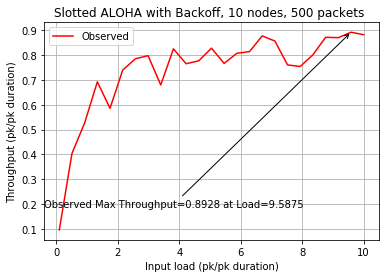

In [52]:
plt.plot(input_G, avr_results, '-r', label='Observed')
plt.title("Slotted ALOHA with Backoff, {} nodes, {} packets ".format(nodes, packets))
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.grid()
localtime = time.asctime( time.localtime(time.time()) )
plt.annotate("Observed Max Throughput={} at Load={}".format(np.around(throughput_max,4), G_max), xy=(G_max, throughput_max) , arrowprops=dict(arrowstyle="->"), textcoords='axes fraction', xytext=(0,0.15))
#plt.savefig("s-aloha-with-backoff at {}".format(localtime))

Comparison for 4 nodes, 50 packets with ALOHA without buffer/backoff

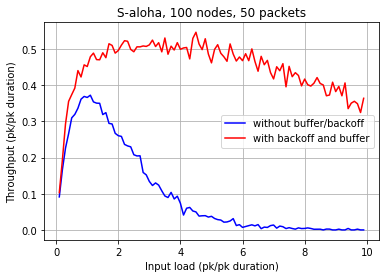

In [350]:
localtime = time.asctime( time.localtime(time.time()) )
df1=pd.read_csv("s-aloha-latest.csv")
plt.plot(df1['load'], df1['tput'], '-b', label='without buffer/backoff')
df2=pd.read_csv("s-aloha-backoff-latest.csv")
plt.plot(df2['load'], df2['tput'], '-r', label='with backoff and buffer')
plt.title("S-aloha, {} nodes, {} packets".format(nodes, packets))
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.grid()
plt.savefig("Comparison at {}".format(localtime))

In [351]:
df4=pd.read_csv("s-aloha-backoff-4-nodes-50-packets.csv")
df10=pd.read_csv("s-aloha-backoff-10-nodes-50-packets.csv")
df20=pd.read_csv("s-aloha-backoff-20-nodes-50-packets.csv")
df30=pd.read_csv("s-aloha-backoff-30-nodes-50-packets.csv")
df50=pd.read_csv("s-aloha-backoff-50-nodes-50-packets.csv")
df75=pd.read_csv("s-aloha-backoff-75-nodes-50-packets.csv")
df100=pd.read_csv("s-aloha-backoff-100-nodes-50-packets.csv")

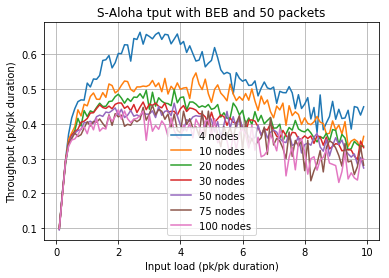

In [352]:
plt.plot(df4['load'], df4['tput'], label="4 nodes")
plt.plot(df10['load'], df10['tput'], label="10 nodes")
plt.plot(df20['load'], df20['tput'], label="20 nodes")
plt.plot(df30['load'], df30['tput'], label="30 nodes")
plt.plot(df50['load'], df50['tput'], label="50 nodes")
plt.plot(df75['load'], df75['tput'], label="75 nodes")
plt.plot(df100['load'], df100['tput'], label="100 nodes")
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.title("S-Aloha tput with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha tput with BEB and 50 packets")

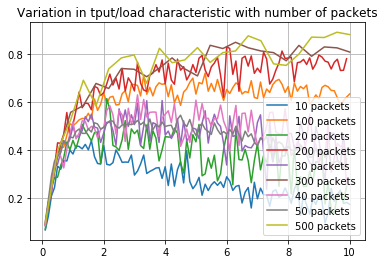

In [56]:
for filename in glob.glob("./*10-nodes*.csv"):
    df=pd.read_csv(filename)
    temp=re.findall(r'\d+', filename)
    plt.plot(df['load'], df['tput'], label="{} packets".format(int(temp[1])))
    plt.legend()
plt.grid()
plt.title("Variation in tput/load characteristic with number of packets")
plt.savefig("Variation in tput-load characteristic with number of packets")

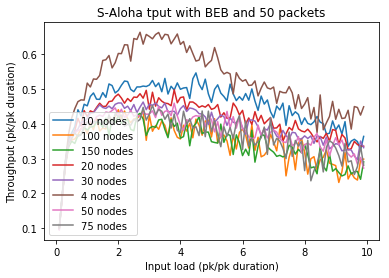

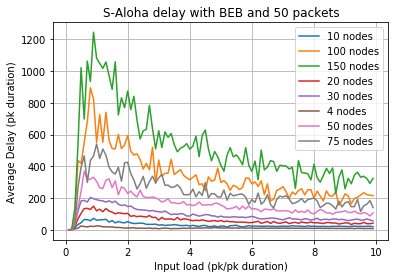

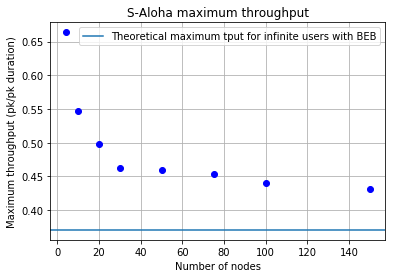

In [363]:
max_tput=[]
load=[]
nodes=[]

for filename in glob.glob("./*nodes*50-packets.csv"):
    df=pd.read_csv(filename)
    max_tput.append(np.amax(df['tput']))
    temp=re.findall(r'\d+', filename)
    nodes.append(int(temp[0]))
    plt.figure(1)
    plt.grid()
    plt.plot(df['load'], df['tput'], label="{} nodes".format(int(temp[0])))
    plt.legend()
    plt.grid()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Throughput (pk/pk duration)")
    plt.title("S-Aloha tput with BEB and 50 packets")
    plt.figure(2)
    plt.plot(df['load'], df['delay'], label="{} nodes".format(int(temp[0])))
    plt.legend()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Average Delay (pk duration)")
    plt.title("S-Aloha delay with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha delay with BEB and 50 packets")
plt.figure(3)
plt.plot( nodes, max_tput, 'ob')
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Maximum throughput (pk/pk duration)")
plt.title("S-Aloha maximum throughput")
plt.axhline(y=0.3706, label="Theoretical maximum tput for infinite users with BEB")
plt.legend()
plt.savefig("Max throughput variation with number of users")



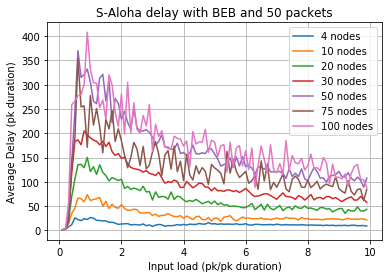

In [291]:
plt.plot(df4['load'], df4['delay'], label="4 nodes")
plt.plot(df10['load'], df10['delay'], label="10 nodes")
plt.plot(df20['load'], df20['delay'], label="20 nodes")
plt.plot(df30['load'], df30['delay'], label="30 nodes")
plt.plot(df50['load'], df50['delay'], label="50 nodes")
plt.plot(df75['load'], df75['delay'], label="75 nodes")
plt.plot(df100['load'], df100['delay'], label="100 nodes")
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Average Delay (pk duration)")
plt.title("S-Aloha delay with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha delay with BEB and 50 packets")